In [1]:
%cd ..

/home/dani2442/Projects/TrafficFlow


/home/dani2442/Projects/TrafficFlow/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

# Traffic Flow 
![](../figures/traffic_flow_taxonomy.png)

In [3]:
V_0 = 50 # Desired speed (km/h)
T = 1.2/3600 # Time gap (h)
rho_max = 120 # Maximum density (veh/km)

#V_0 = 110
#T = 1.4/3600
#rho_max = 120

l_eff = 1/rho_max # Inverse of the minimum distance headway
rho_C = 1/(V_0*T + l_eff) # Critical value between free traffic and congested traffic

@jax.jit
def Q_e(rho):
    return jnp.maximum(0, jnp.where(rho<=rho_C, V_0*rho, (1-rho*l_eff)/T))

@jax.jit
def dQ_e(rho):
    return jnp.where(rho<=rho_C, V_0, -l_eff/T)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


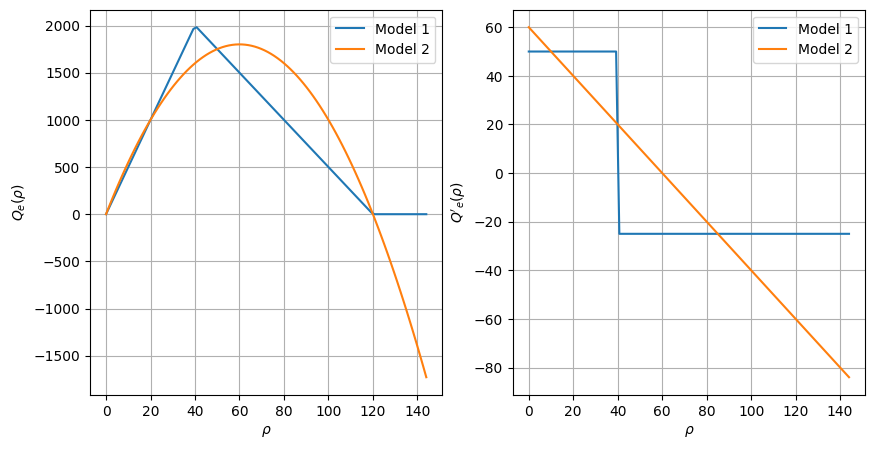

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
rho_linspace = np.linspace(0, 1.2*rho_max, 100)
axs[0].plot(rho_linspace, Q_e(rho_linspace), label='Model 1')
axs[0].plot(rho_linspace, 0.5*rho_linspace*(rho_max-rho_linspace), label='Model 2')
axs[1].plot(rho_linspace, dQ_e(rho_linspace), label='Model 1')
axs[1].plot(rho_linspace, 0.5*rho_max - rho_linspace, label='Model 2')
axs[0].set_ylabel("$Q_e(\\rho)$")
axs[0].set_xlabel("$\\rho$")
axs[1].set_xlabel("$\\rho$")
axs[1].set_ylabel("$Q'_e(\\rho)$")
axs[1].grid()
axs[0].grid()
axs[0].legend()
axs[1].legend()
plt.show()

In [5]:
x_0, x_N = 0, 100
N_x = 101
T_sim = 2
N_t = 1000

dx = (x_N - x_0)/(N_x-1)
dt = T_sim/N_t

xs = jnp.linspace(x_0, x_N, N_x)
rho_0x = rho_max/4 + jnp.exp(-jnp.square((xs - x_N/2)/20))*rho_max/2
rho_t0 = rho_max/4 + jnp.zeros(N_t) 
rho_t1 = rho_max/4 + jnp.zeros(N_t) 

In [6]:
print("dx: ", dx, "\ndt: ", dt)
print("Courant-Friedrichs-Lévy condition (CFL condition) for LWR models: ", dt*max(V_0, l_eff/T)/dx)

dx:  1.0 
dt:  0.002
Courant-Friedrichs-Lévy condition (CFL condition) for LWR models:  0.1


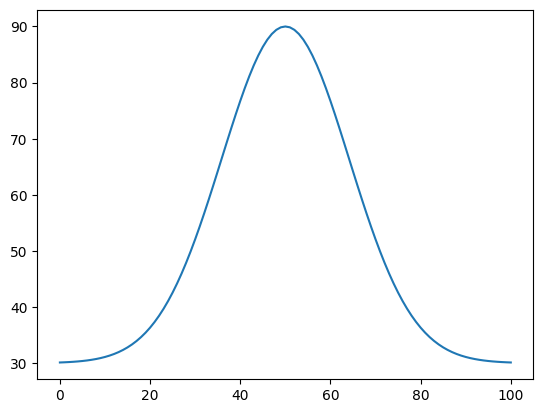

In [7]:
plt.plot(rho_0x)

# Method 1

$$
\frac{\rho_k (t_{i+1}) - \rho_k(t_i)}{\Delta t} + \frac{dQ_e(\rho_k(t_i))}{d\rho}\frac{\rho_{k+1}(t_i) - \rho_{k-1}(t_i)}{2\Delta x} = 0
$$

In [8]:
rho = np.zeros((N_t, N_x))
rho[0,:] = rho_0x
rho[:,0] = rho_t0
rho[:,-1] = rho_t1

for t_i in range(N_t-1):
    rho[t_i+1, 1:-1] = 0.5*(rho[t_i, 2:]+ rho[t_i, :-2]) - dt*dQ_e(rho[t_i, 1:-1])*(rho[t_i, 2:] - rho[t_i, :-2])/(2*dx)

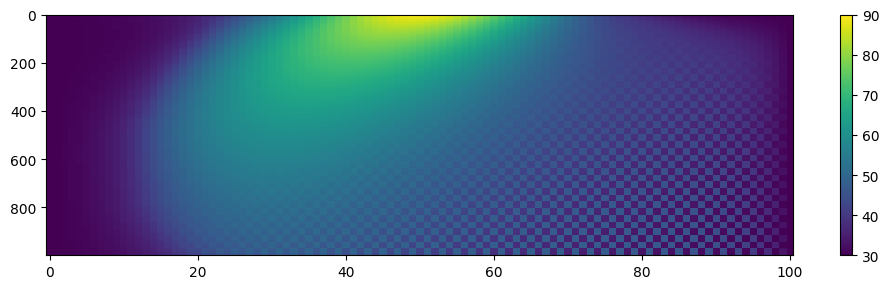

In [9]:
f, ax = plt.subplots(1, figsize=(10,3))
pos = ax.imshow(rho, aspect='auto', interpolation='none')
f.colorbar(pos, ax=ax)
plt.tight_layout()

# Method ii

In [70]:
rho = np.zeros((N_t, N_x))
rho[0,:] = rho_0x
rho[:,0] = rho_t0
rho[:,-1] = rho_t1

total_rho = jnp.sum(rho[t_i,1:-1])
for t_i in range(N_t-1):
    b = rho[t_i,1:-1]
    b[0] += dt/(2*dx)*dQ_e(rho[t_i, 0])*rho[t_i+1, 0]
    b[-1] -= dt/(2*dx)*dQ_e(rho[t_i, -1])* rho[t_i+1, -1]

    A = jnp.eye(N_x-2) + jnp.diag(dt/(2*dx)*dQ_e(rho[t_i,2:-1]), k=1 ) + jnp.diag(-dt/(2*dx)*dQ_e(rho[t_i,1:-2]), k=-1)
    rho[t_i+1, 1:-1] = jnp.linalg.inv(A) @ b
    rho[t_i+1,1:-1] *= total_rho/jnp.sum(rho[t_i+1, 1:-1])

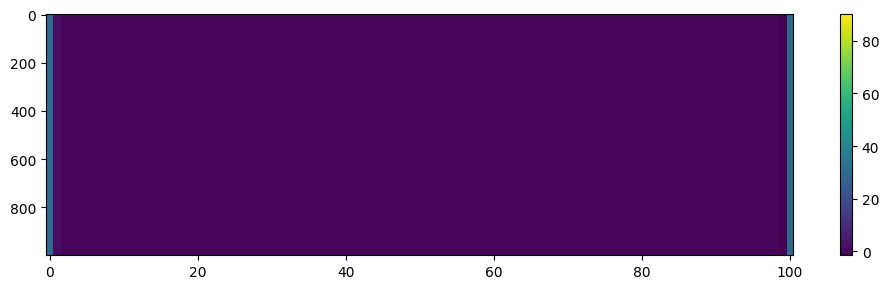

In [71]:
f, ax = plt.subplots(1, figsize=(10,3))
pos = ax.imshow(rho, aspect='auto', interpolation='none')
f.colorbar(pos, ax=ax)
plt.tight_layout()

# Method iii

$$
\frac{\rho_k (t_{i+1}) - \rho_k(t_i)}{\Delta t} + \frac{dQ_e(\rho_k(t_i))}{d\rho}\frac{\rho_{k}(t_i) - \rho_{k-1}(t_i)}{\Delta x} = 0
$$

In [79]:
rho_max

120

In [94]:
rho = np.zeros((N_t, N_x))
rho[0,:] = rho_0x
rho[:,0] = rho_t0
rho[:,-1] = rho_t1

for t_i in range(N_t-1):
    rho[t_i+1, 1:-1] = 0.5*rho[t_i,1:-1] + 0.25*(rho[t_i, 2:]+ rho[t_i, :-2]) - dt*dQ_e(rho[t_i, 1:-1])*(rho[t_i, 2:] - rho[t_i, :-2])/(2*dx)

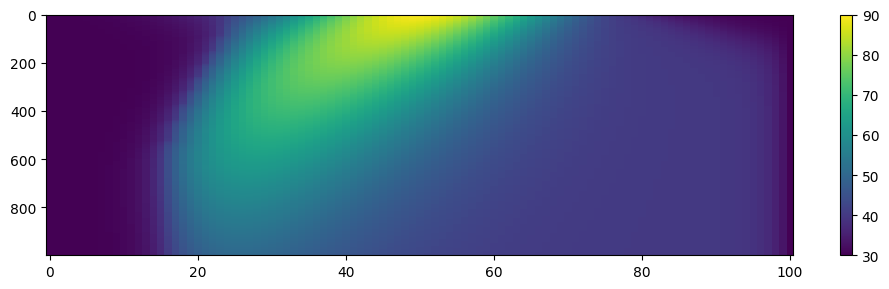

In [95]:
f, ax = plt.subplots(1, figsize=(10,3))
pos = ax.imshow(rho, aspect='auto', interpolation='none')
f.colorbar(pos, ax=ax)
plt.tight_layout()

# Method 1

$$
\frac{\rho_k (t_{i+1}) - \rho_k(t_i)}{\Delta t} + \frac{dQ_e(\rho_k(t_i))}{d\rho}\frac{\rho_{k+1}(t_i) - \rho_{k-1}(t_i)}{2\Delta x} = 0
$$

In [18]:
rho = np.zeros((N_t, N_x))
rho[0,:] = rho_0x
rho[:,0] = rho_t0
rho[:,-1] = rho_t1

for t_i in range(N_t-1):
    rho[t_i+1, 1:-1] = 0.5*(rho[t_i, 2:] + rho[t_i, :-2]) - dt/(2*dx)*dQ_e(rho[t_i, 1:-1])*(rho[t_i, 2:] - rho[t_i, :-2])

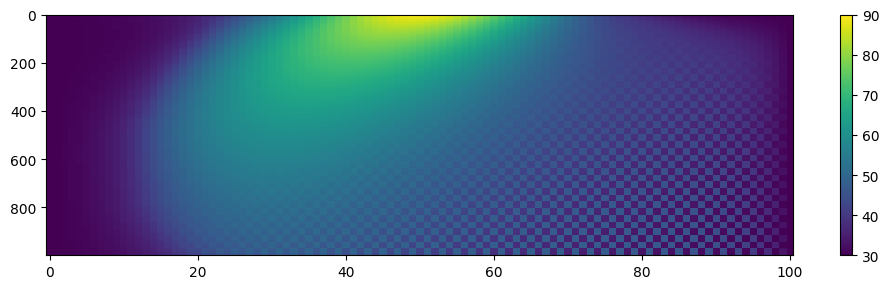

In [19]:
f, ax = plt.subplots(1, figsize=(10,3))
pos = ax.imshow(rho, aspect='auto', interpolation='none')
f.colorbar(pos, ax=ax)
plt.tight_layout()